# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [170]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt

import random

In [171]:
dt = pd.read_table('orange_small_churn_data.txt', sep=',')
labels = pd.read_table('orange_small_churn_labels.txt', header=None)

In [172]:
dt.shape

(40000, 230)

2\. Рассчитайте доли классов `отток` и `не отток`.

In [173]:
labels.value_counts(normalize=True)

-1    0.9256
 1    0.0744
dtype: float64

3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

In [174]:
dt_digits = dt.iloc[:, :190]
dt_category = dt.iloc[:, 190:]

##### Категориальные переменные

Будем расчитывать коэффицент V-Крамера

https://www.coursera.org/lecture/stats-for-data-analysis/korrieliatsiia-met-iusa-i-koeffitsiient-kramiera-prX3S

In [175]:
uniq_val_category = dt_category.nunique().sort_values()
uniq_val_category[uniq_val_category < 2] .sum()
# У нас 4 переменные, у которых значенея не изменяются. Удалим их, они нам не дадут никакой информации

4

In [176]:
dt_category.drop(uniq_val_category[uniq_val_category < 2].index, axis=1, inplace=True)

In [177]:
dt_category['label'] = labels

In [178]:
correlation_cat = pd.Series()

<ipython-input-178-ad672537724b>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  correlation_cat = pd.Series()


In [179]:
for name in dt_category.columns:
    confusion_mx = pd.crosstab(dt_category['label'], dt_category[name]) # матрица сопряженности
    chi = ss.chi2_contingency(confusion_mx)[0]
    correlation_cat[name] = np.sqrt(chi / (dt_category.shape[0] * (min(confusion_mx.shape[0], confusion_mx.shape[1]) - 1)))

##### Числовые переменные

Для измерения коррелированности ьинарной переменной и числовой будем использовать Point-biserial correlation 
coefficient

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html

In [180]:
uniq_val_digits = dt_digits.nunique().sort_values()
uniq_val_digits[uniq_val_digits == 0].sum()
# 16 переменных, которые не имеют значений, удалим их.

0

In [181]:
uniq_val_digits[uniq_val_digits == 1] .sum()
# 1 переменная, которая не меняет своего значений, для прогноза она нам ничгео не даст, удалим её

1

In [182]:
dt_digits.drop(uniq_val_digits[uniq_val_digits < 2].index, axis=1, inplace=True)

In [183]:
dt_digits['label'] = labels
correlation_dig = pd.Series(name='corr')

<ipython-input-183-f05d8b6db9cd>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  correlation_dig = pd.Series(name='corr')


In [184]:
for name in dt_digits.columns[:-1]:
    # Point-Biserial Correlation, между непрерывной и бинарной. Для подсчета не должно быть пропусков
    # при расчете коррелируемости я не рассматривала строки с пропусками в текущей переменной
    temp = dt_digits[['label', name]].dropna()
    correlation_dig[name] = ss.pointbiserialr(temp['label'], temp[name])[0] 

4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

Распределние плотностей переменных


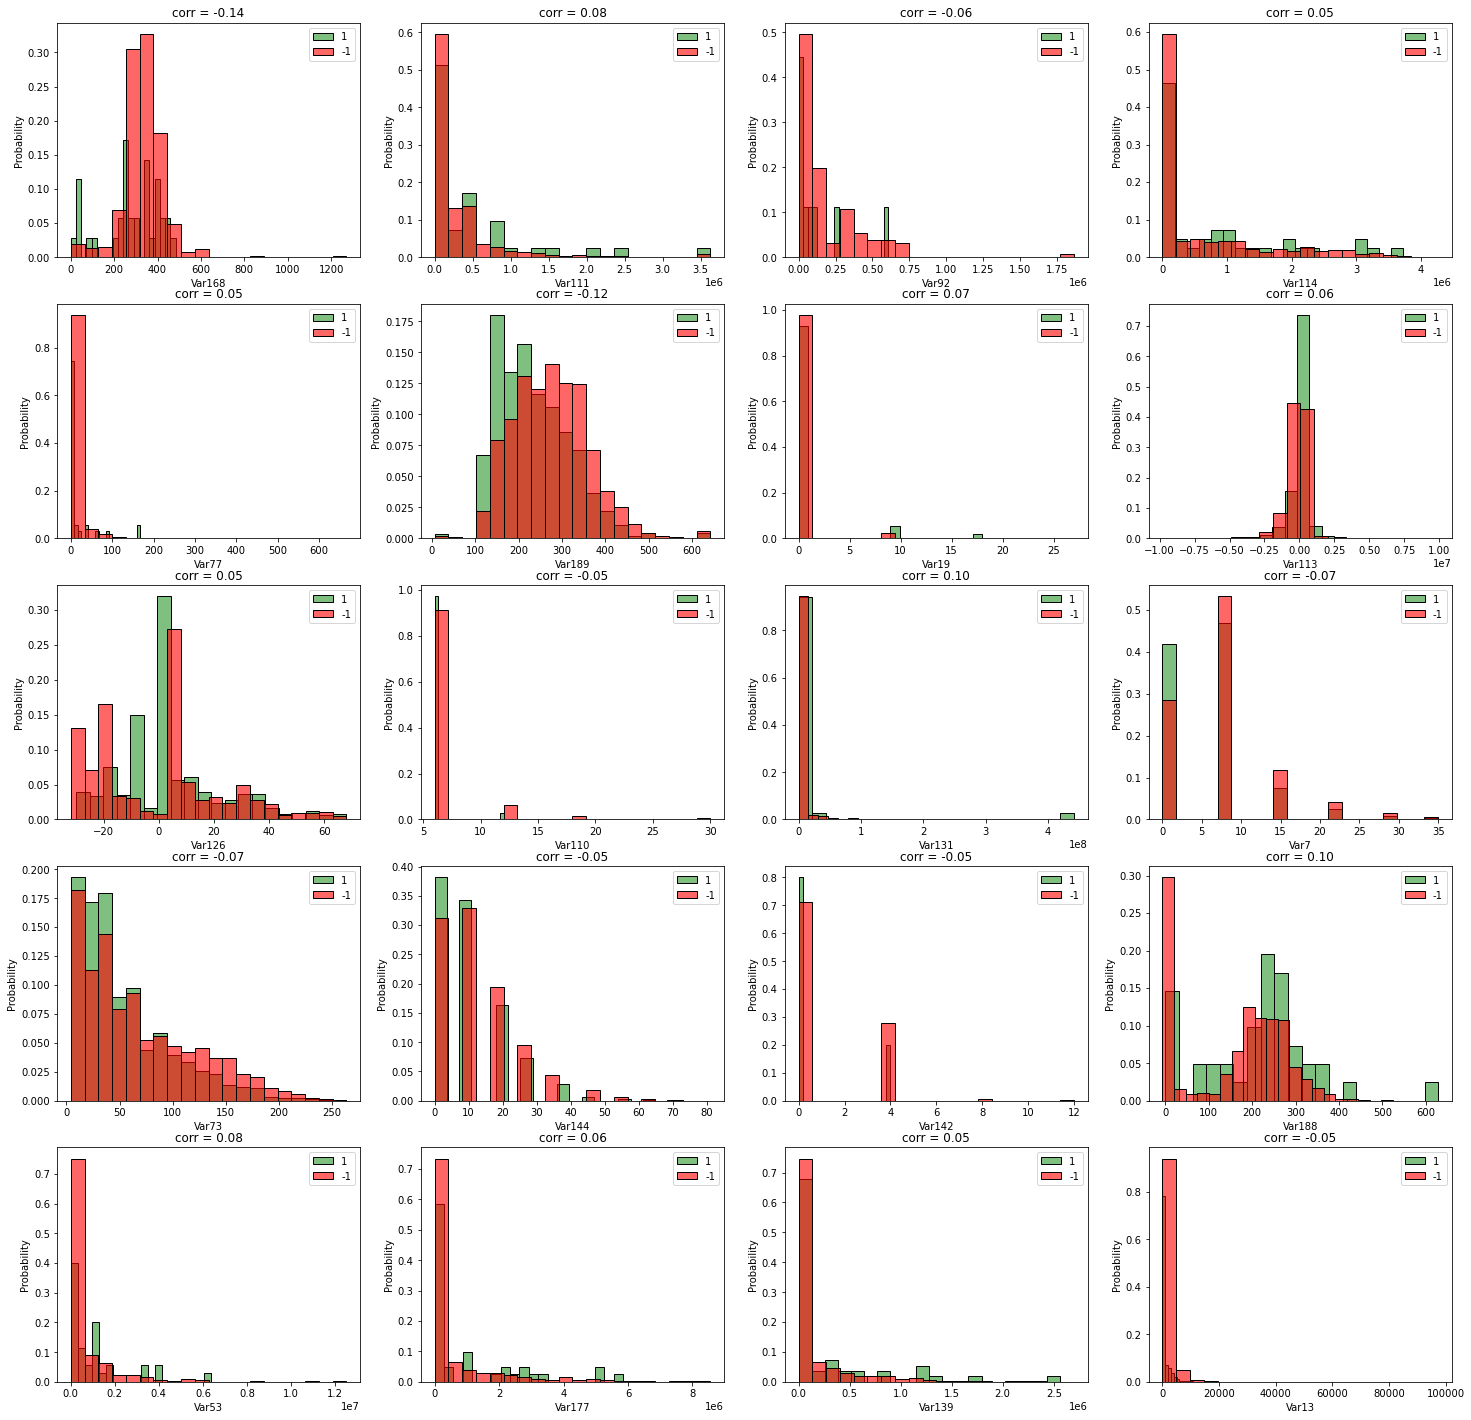

In [121]:
first_20 = np.abs(correlation_dig).sort_values(ascending=False).head(20).index
fig, axes = plt.subplots(5, 4, figsize=(25, 25))
for k, name in enumerate(first_20):
    sns.histplot(dt_digits[dt_digits['label'] == 1][name], stat='probability', color='g', alpha=0.5, label='1', bins=20, ax=axes[k % 5, k % 4])
    sns.histplot(dt_digits[dt_digits['label'] == -1][name], stat='probability', color='r', alpha=0.6, label='-1', bins=20, ax=axes[k % 5, k % 4])
    axes[k % 5, k % 4].legend()
    axes[k % 5, k % 4].set_title('corr = {:.2f}'.format(correlation_dig[name]))
print('Распределние плотностей переменных')
plt.show()

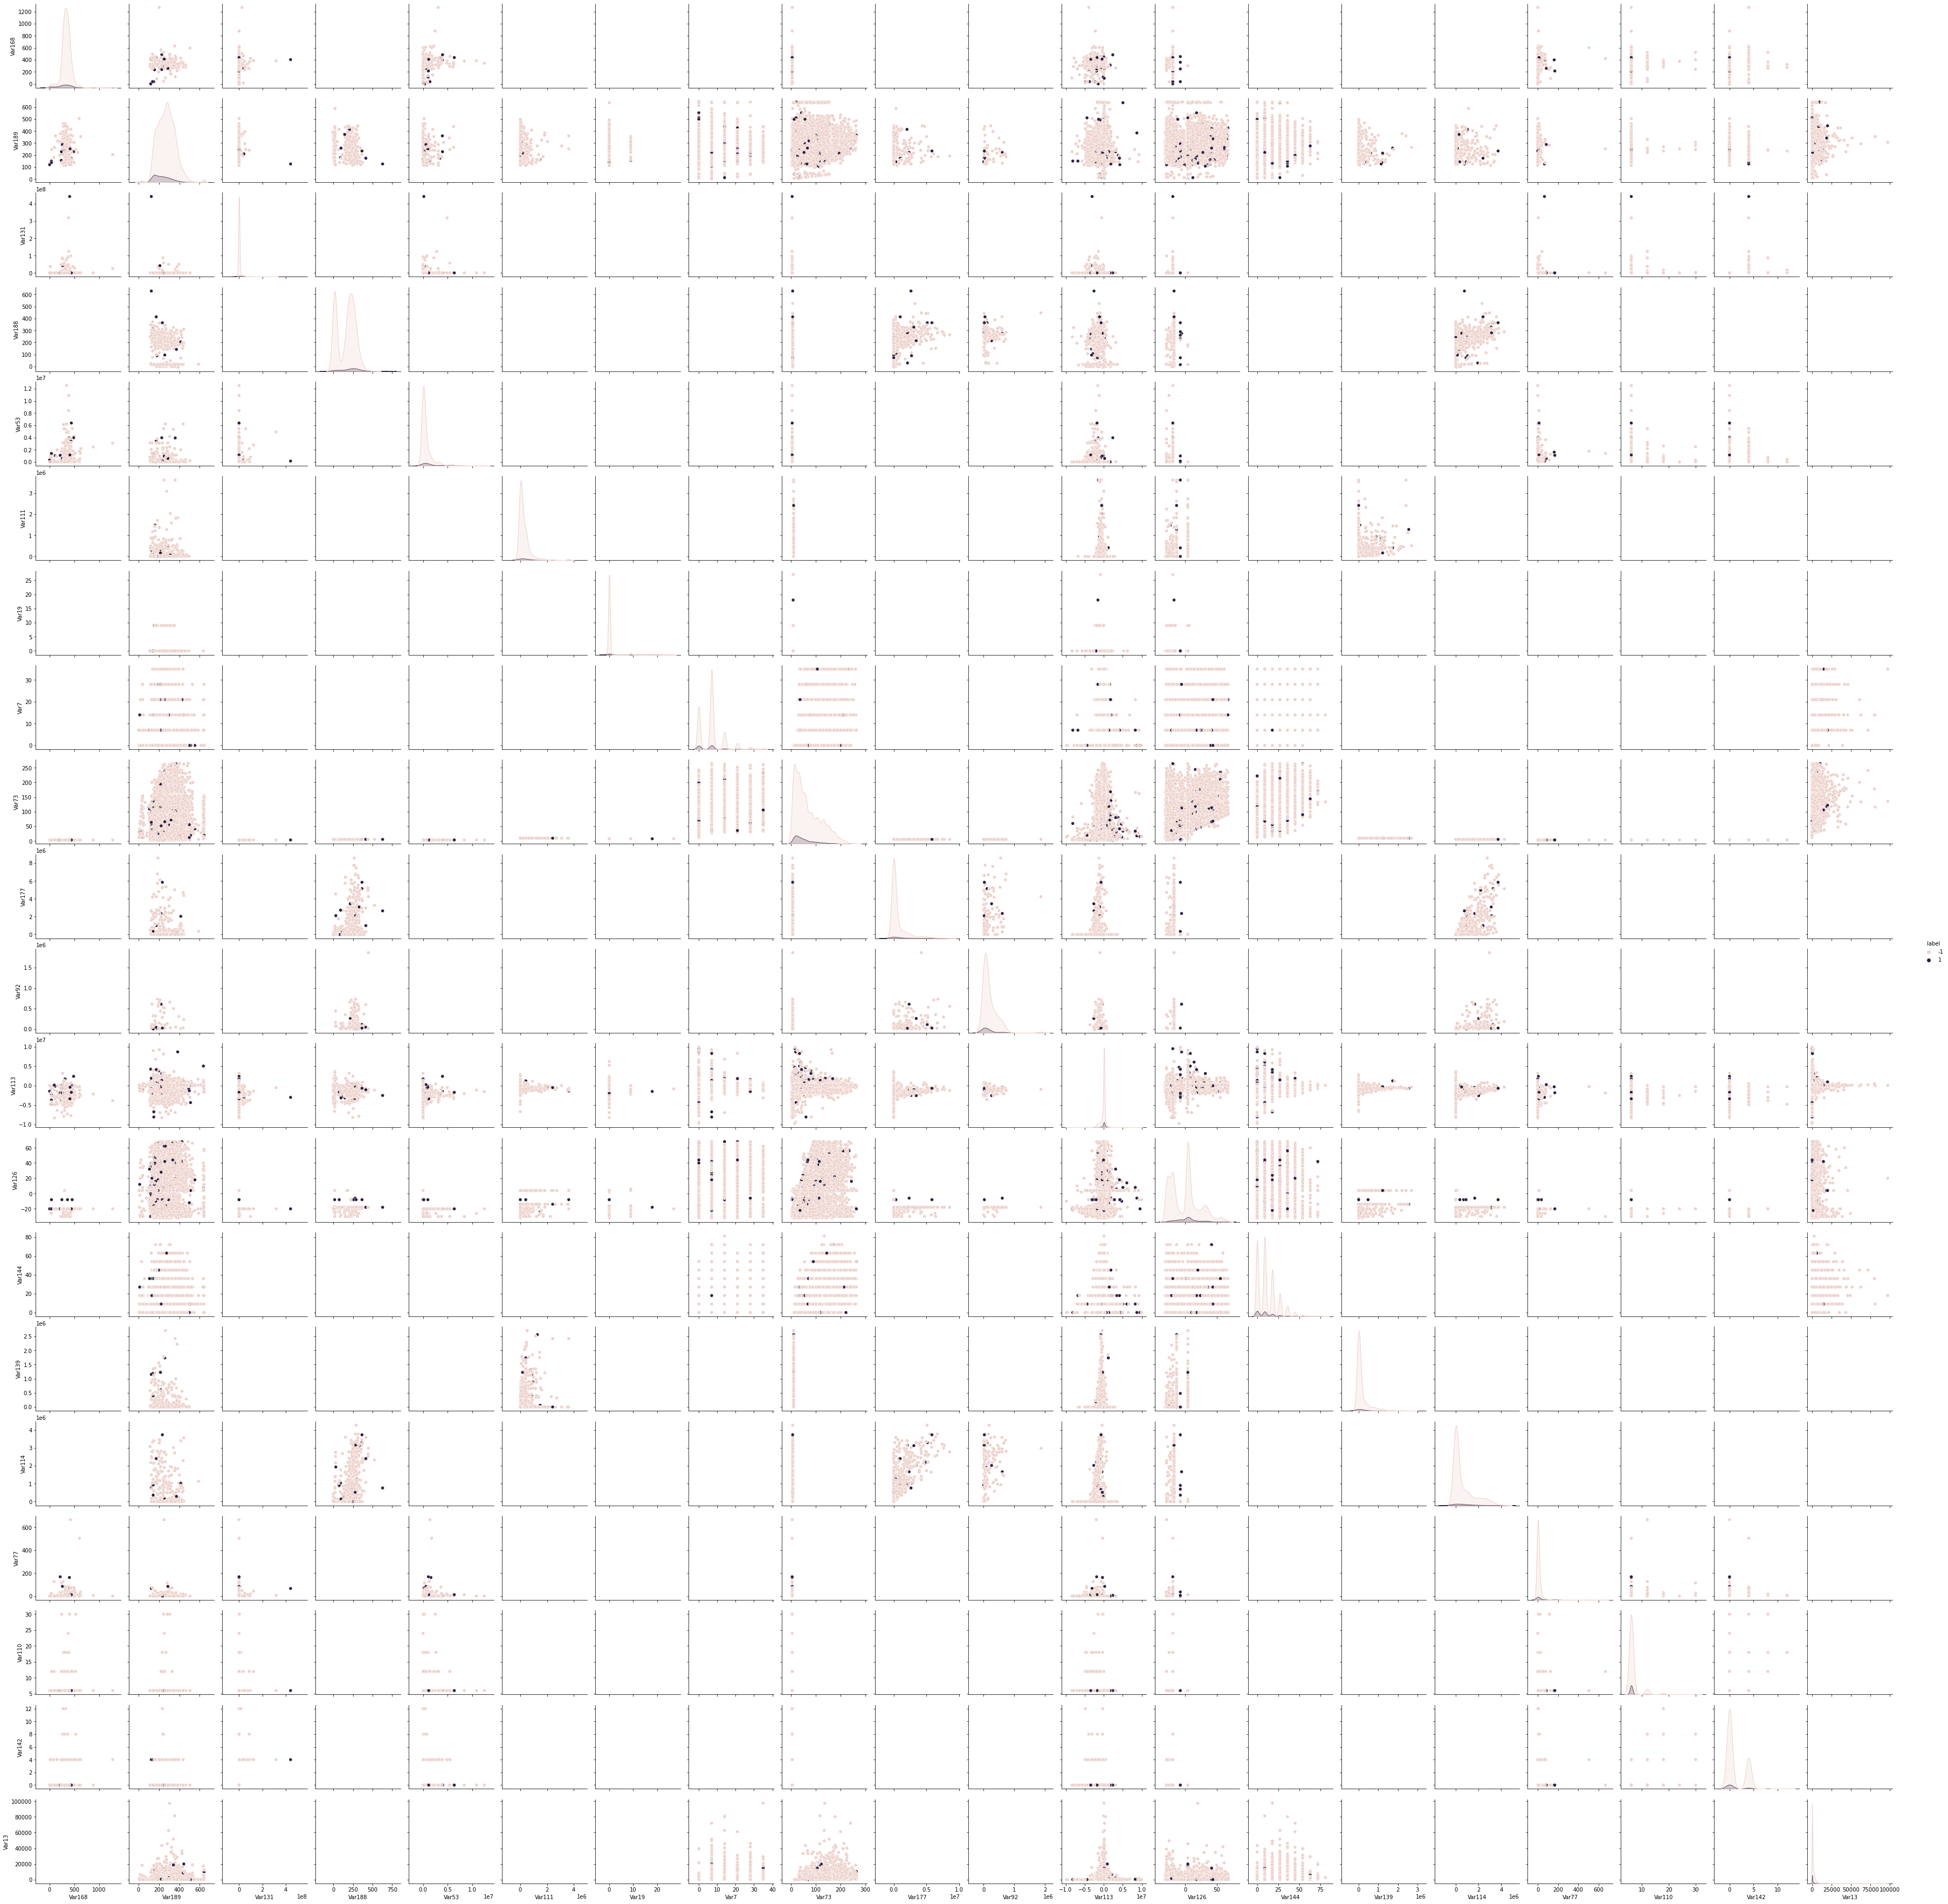

In [122]:
sns.pairplot(data=dt_digits, vars=first_20, hue='label')

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [123]:
random_var = random.sample(list(dt_digits.columns), 10)

Распределние плотностей переменных


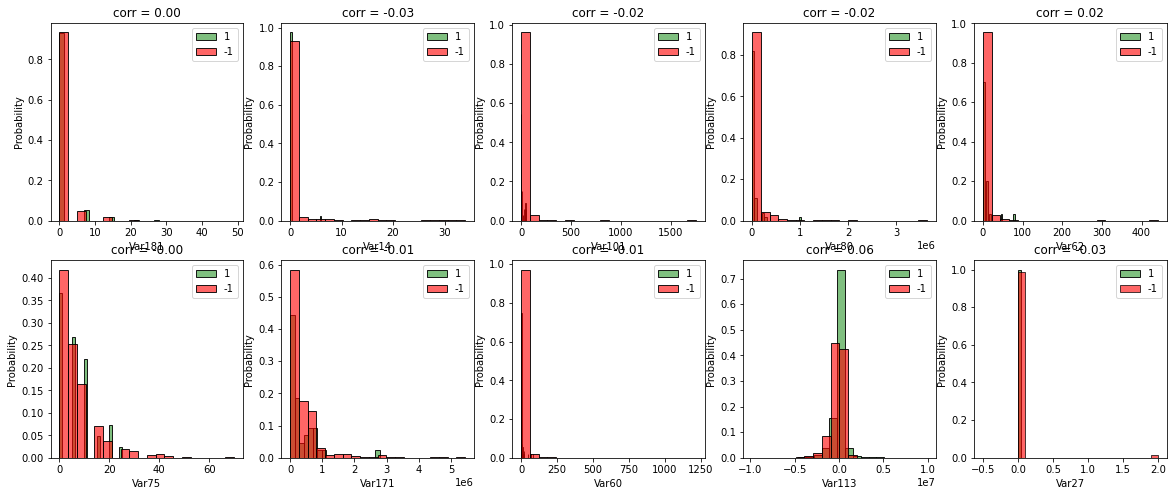

In [124]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for k, name in enumerate(random_var):
    sns.histplot(dt_digits[dt_digits['label'] == 1][name], stat='probability', color='g', alpha=0.5, label='1', bins=20, ax=axes[k % 2, k % 5])
    sns.histplot(dt_digits[dt_digits['label'] == -1][name], stat='probability', color='r', alpha=0.6, label='-1', bins=20, ax=axes[k % 2, k % 5])
    axes[k % 2, k % 5].legend()
    axes[k % 2, k % 5].set_title('corr = {:.2f}'.format(correlation_dig[name]))
print('Распределние плотностей переменных')
# plt.title('Распределние плотностей переменных')
plt.show()

C:\Users\warco\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


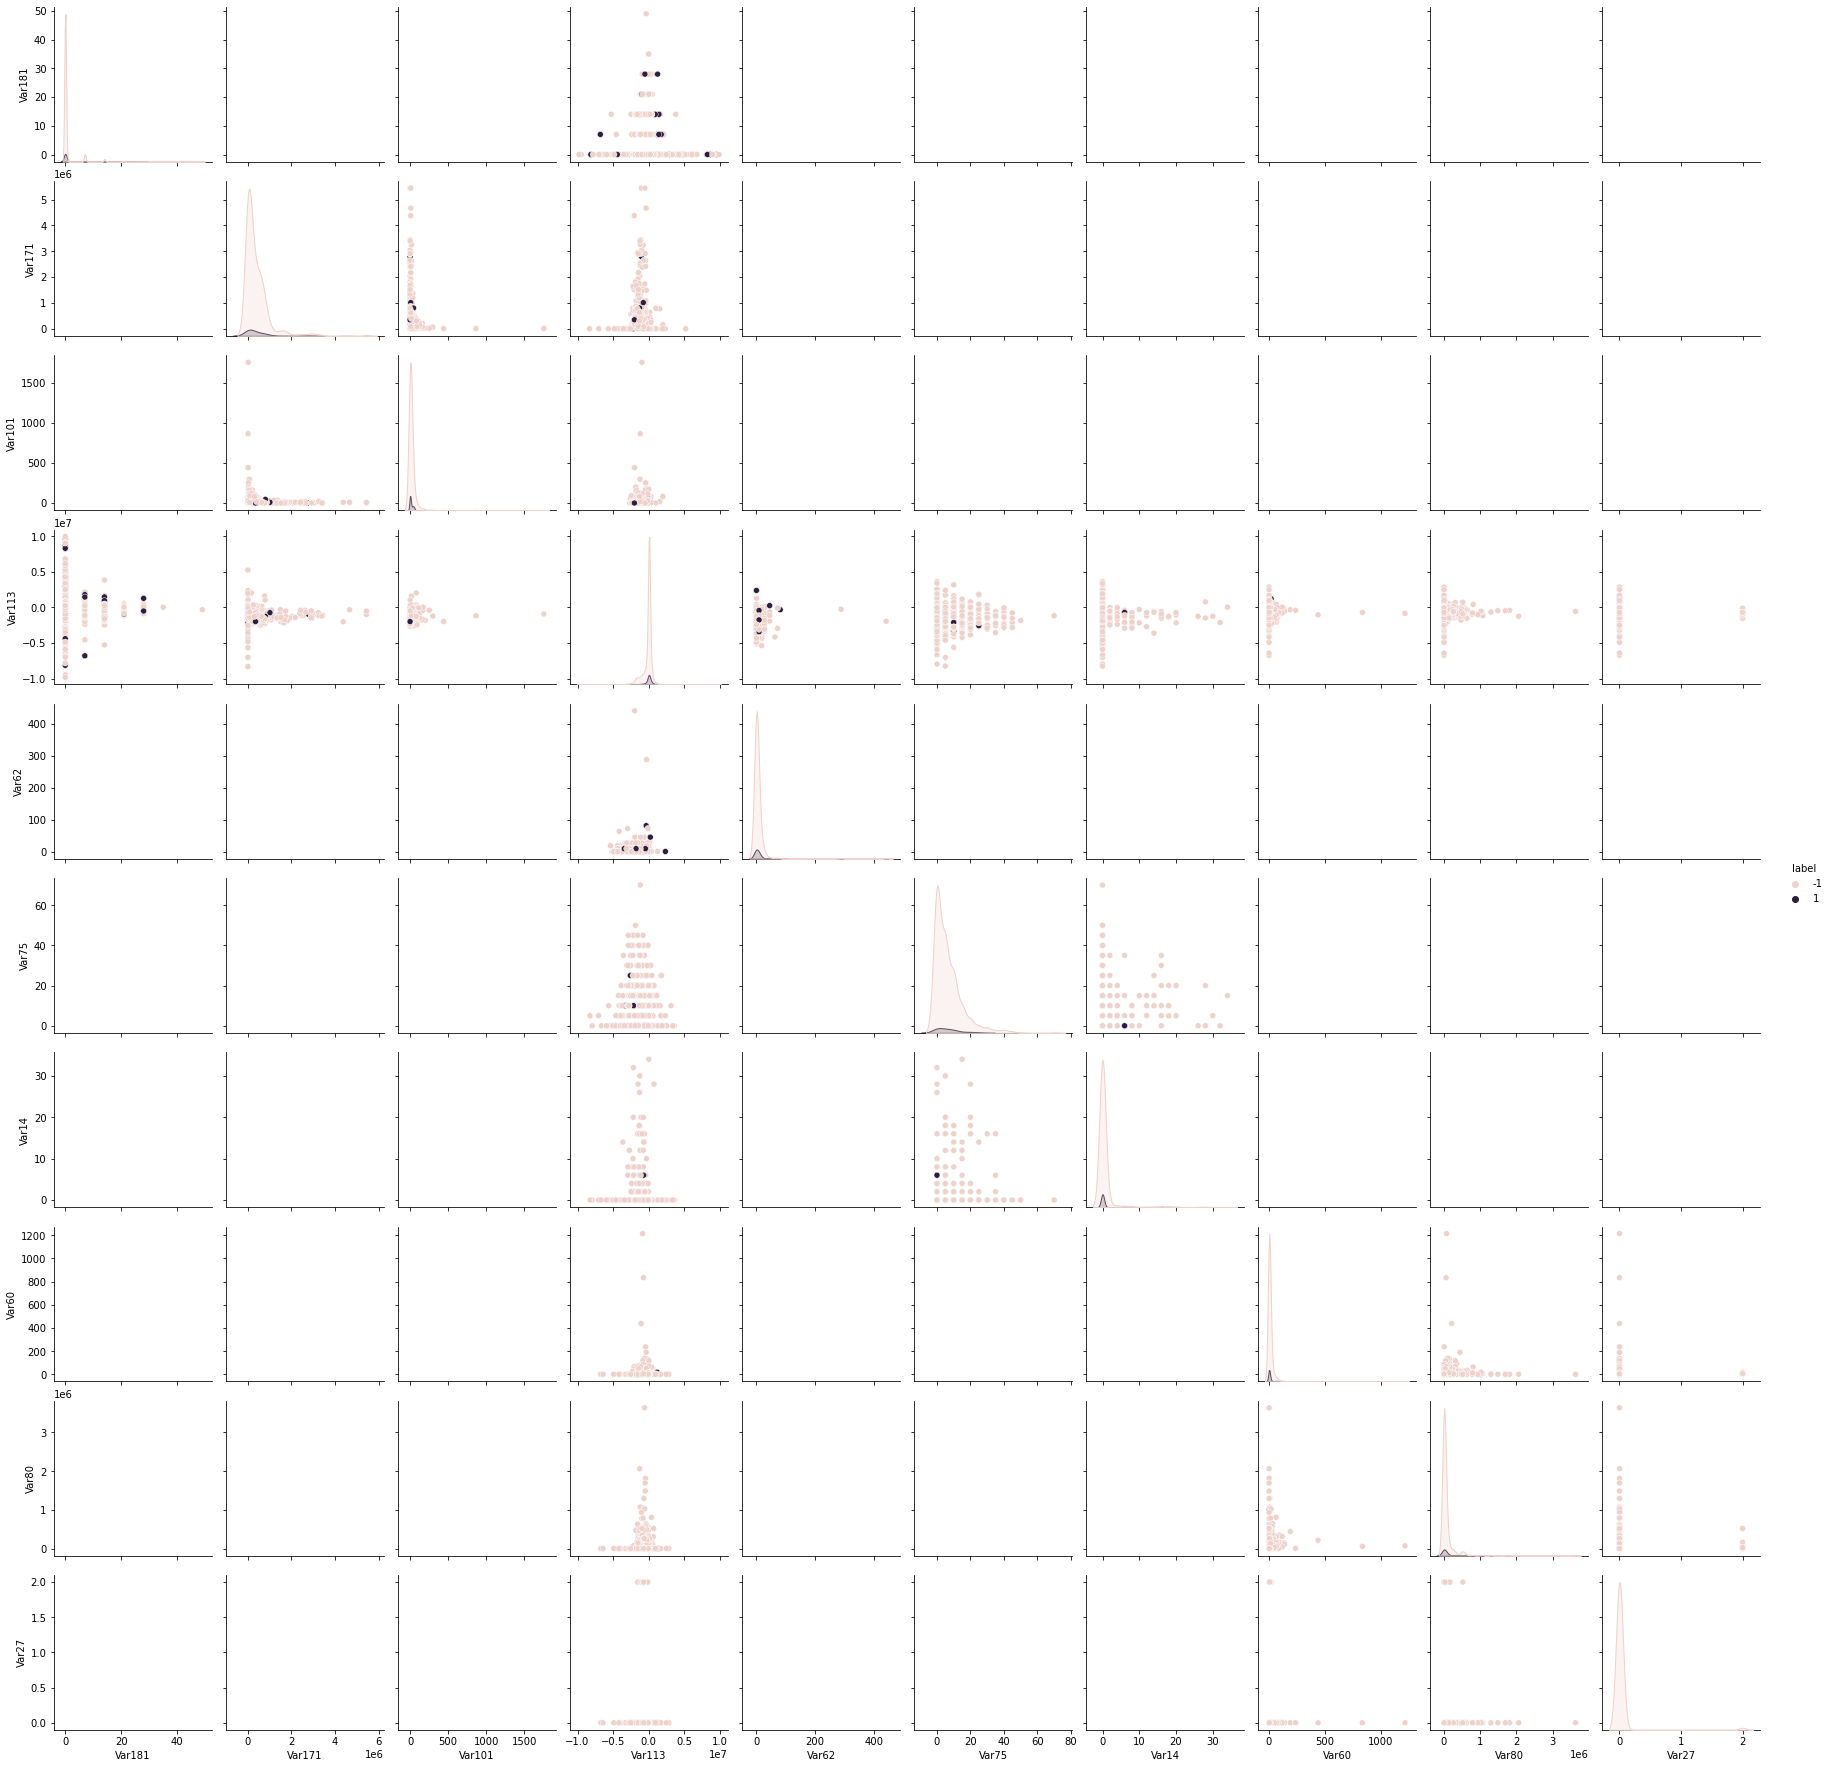

In [125]:
sns.pairplot(data=dt_digits, vars=random_var, hue='label')

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

Распределние плотностей переменных


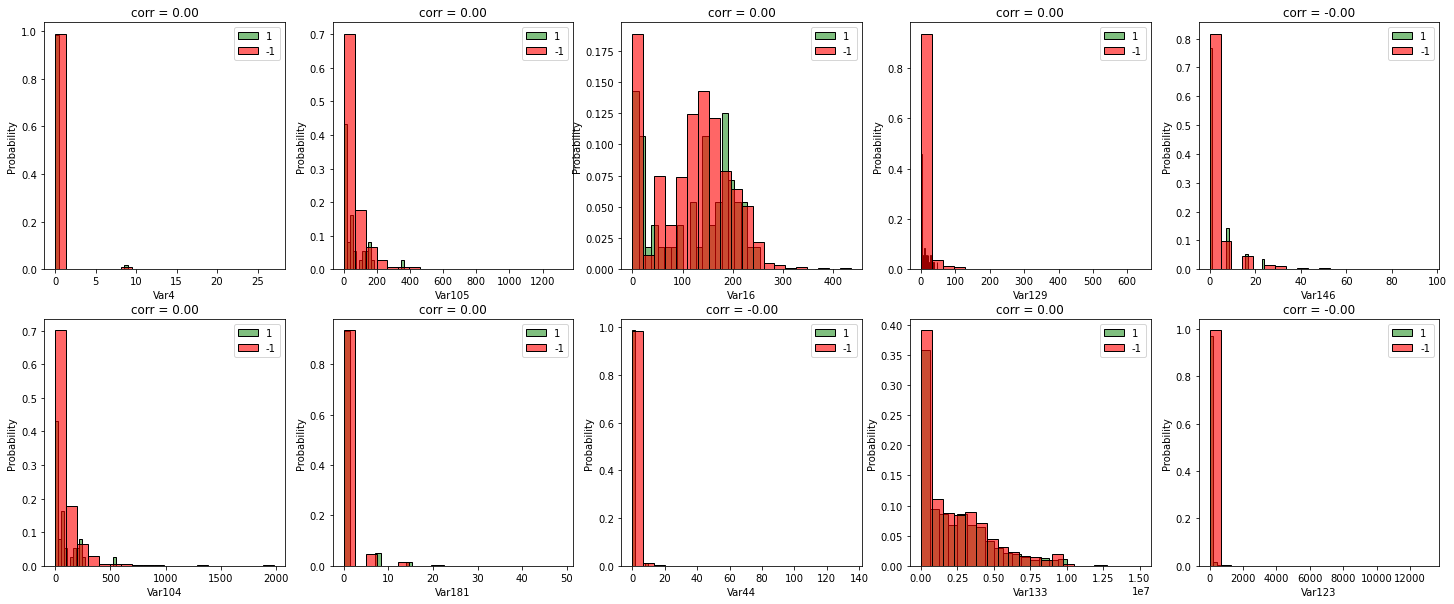

In [126]:
last_20 = np.abs(correlation_dig).sort_values(ascending=False).tail(10).index
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
for k, name in enumerate(last_20):
    sns.histplot(dt_digits[dt_digits['label'] == 1][name], stat='probability', color='g', alpha=0.5, label='1', bins=20, ax=axes[k % 2, k % 5])
    sns.histplot(dt_digits[dt_digits['label'] == -1][name], stat='probability', color='r', alpha=0.6, label='-1', bins=20, ax=axes[k % 2, k % 5])
    axes[k % 2, k % 5].legend()
    axes[k % 2, k % 5].set_title('corr = {:.2f}'.format(correlation_dig[name]))
print('Распределние плотностей переменных')
# plt.title('Распределние плотностей переменных')
plt.show()

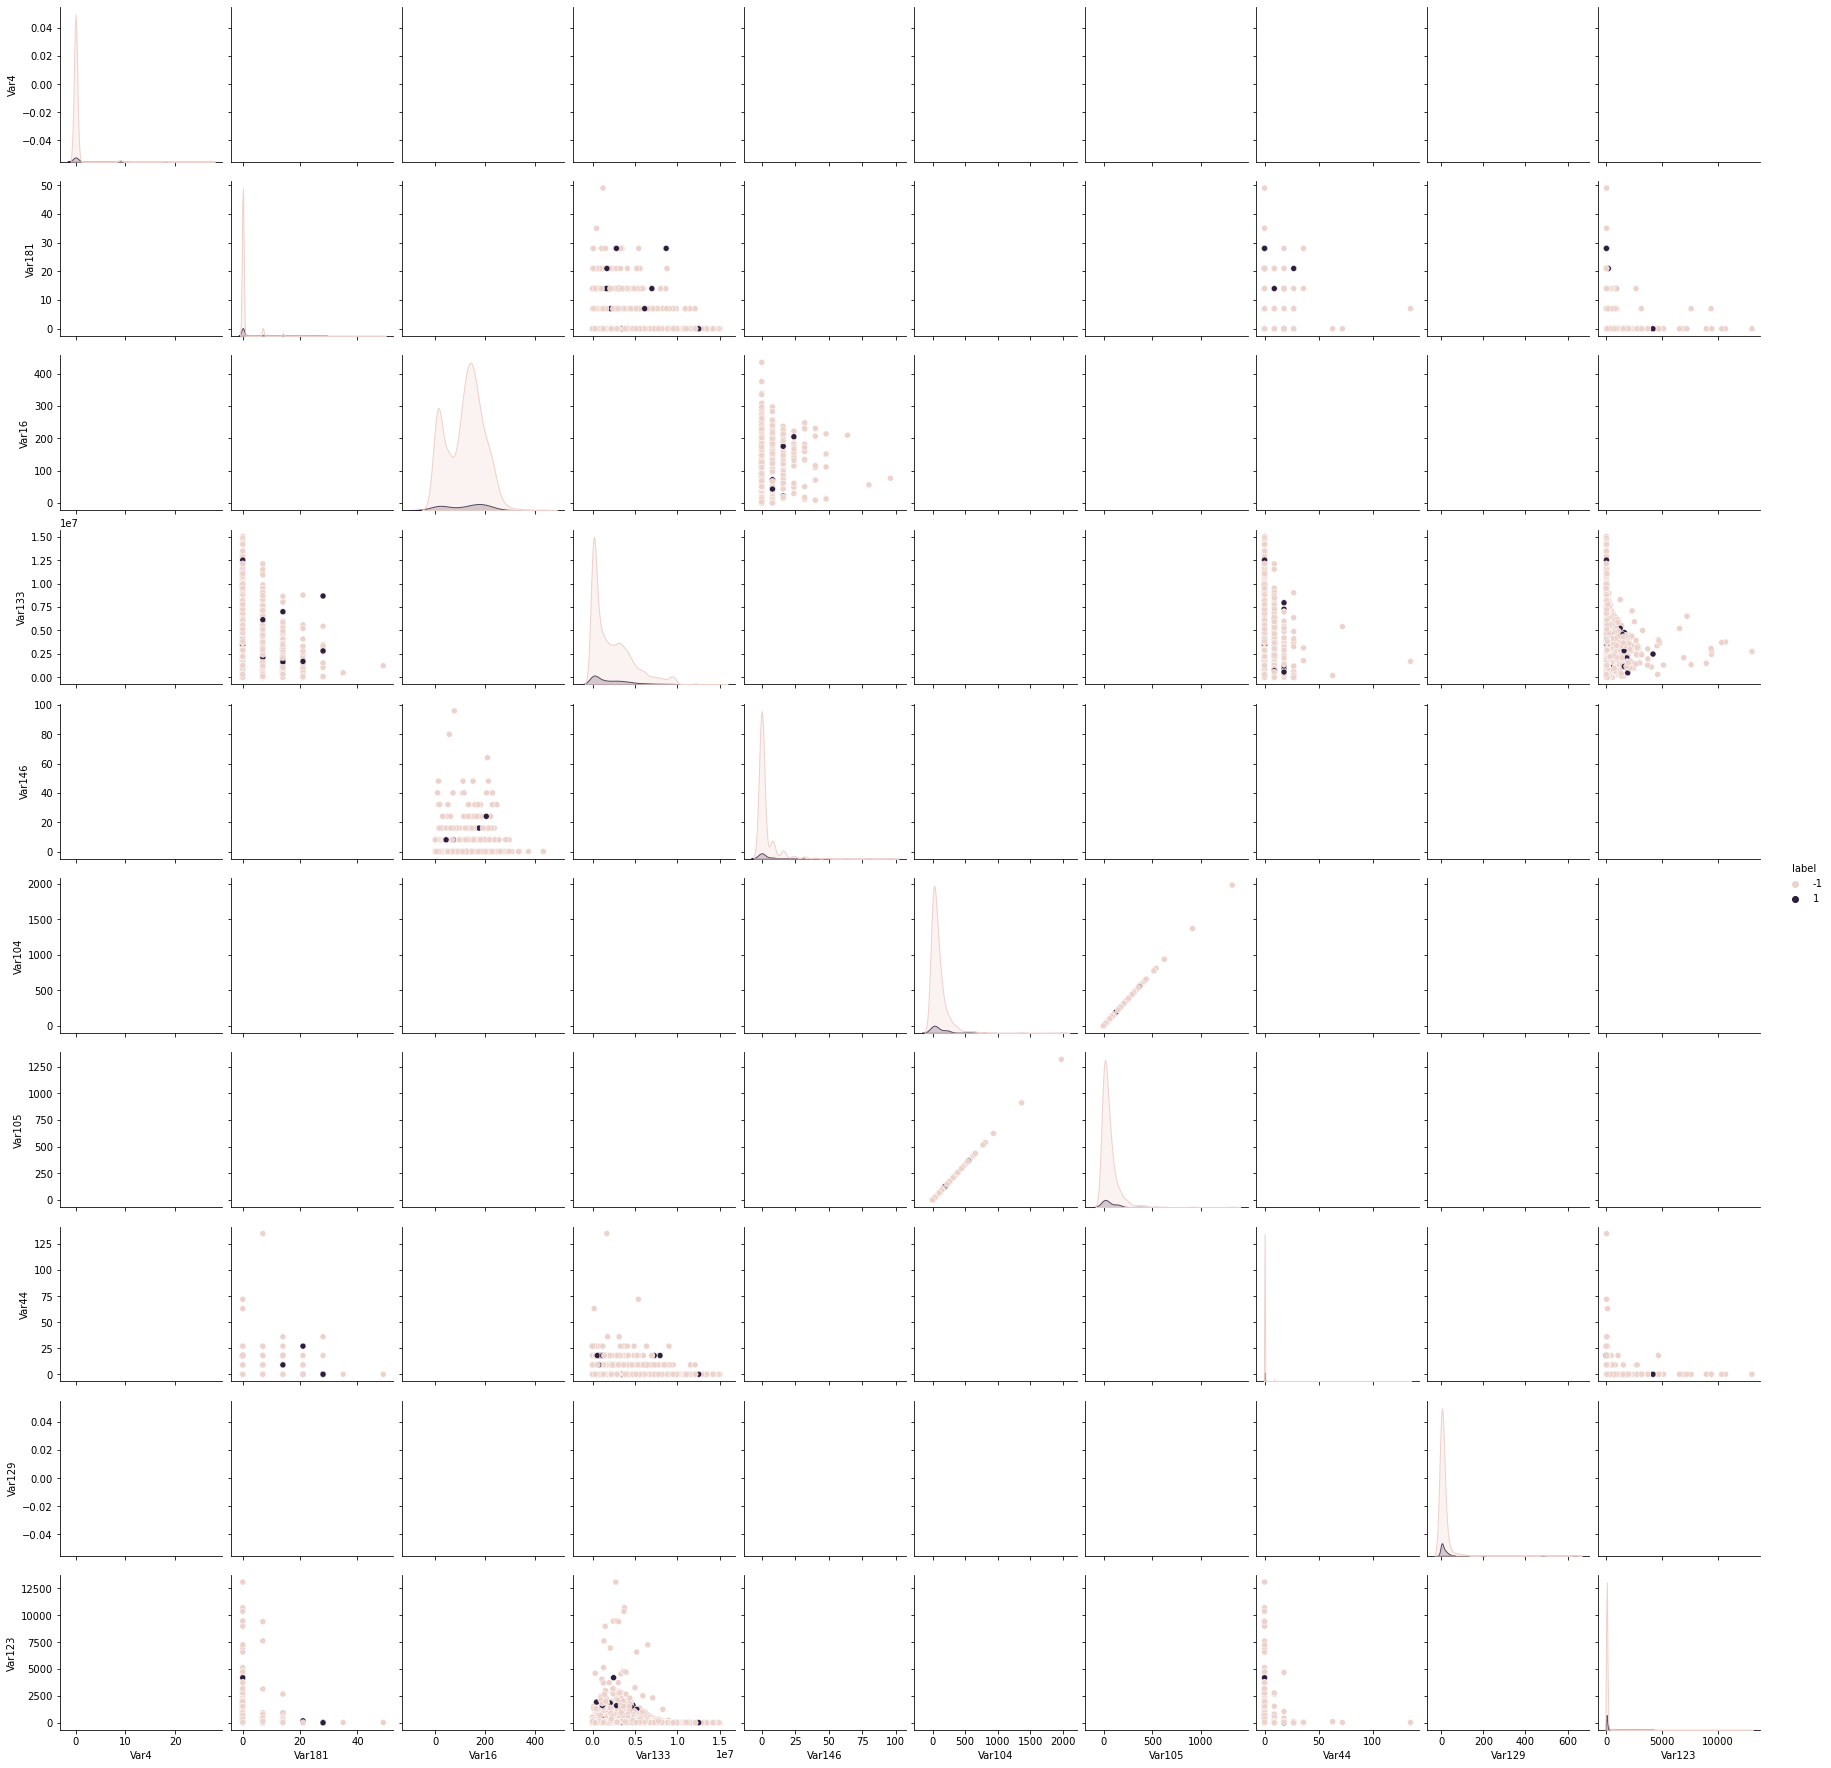

In [127]:
sns.pairplot(data=dt_digits, vars=last_20, hue='label')

### Выводы по коррелированости целевой переменной с числовыми

У наиболее коррелированных пременных распредление относительно целевой переменной отличается. Выделются следующие переменные: 168, 189, 113, 126, 188, 73. Наибольший показалатель коррелированнасти по модулю равен 0.14.

В разрезе пар призаков, я не увидела четких границиц между классами целевой переменной. Переменные 105 и 104 линейно зависимые, но у обеих нулевая коррелирвоаность с целевой переменной.

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

In [185]:
summary = pd.DataFrame({'unique val': dt_category.nunique(), 'corr' : correlation_cat, 'num nan': dt_category.isna().sum()/ dt_category.shape[0]}).sort_values(by='corr', ascending=False).iloc[1:, :]
summary.head()

,unique val,corr,num nan
Var214,13297,0.577336,0.509150
Var200,13297,0.577336,0.509150
Var217,12470,0.531387,0.014000
Var199,4400,0.407821,0.000100
Var202,5542,0.363426,0.000025


In [186]:
correlation_cat = correlation_cat.drop(['Var214', 'Var200'])

In [187]:
# удалим переменные, в которых более 50 % пропусков
dt = dt.drop(['Var214', 'Var200'], axis=1)
dt_category = dt_category.drop(['Var214', 'Var200'], axis=1)
summary = pd.DataFrame({'unique val': dt_category.nunique(), 'corr' : correlation_cat, 'num nan': dt_category.isna().sum()/ dt_category.shape[0]}).sort_values(by='corr', ascending=False).iloc[1:, :]
summary.head()

,unique val,corr,num nan
Var217,12470,0.531387,0.014000
Var199,4400,0.407821,0.000100
Var202,5542,0.363426,0.000025
Var222,3891,0.292593,0.000000
Var220,3891,0.292593,0.000000


In [189]:
for name in summary.index:
    print(dt_category[name].value_counts(normalize=True))

gvA6    0.005426
5smi    0.004843
A1VJ    0.004361
bru6    0.003930
s9FI    0.003600
          ...   
gsz0    0.000025
vWNh    0.000025
HyBS    0.000025
RoRn    0.000025
q6Oa    0.000025
Name: Var217, Length: 12470, dtype: float64
r83_sZi          0.018652
_jTP8ioIlJ       0.018527
FoJylxy          0.015402
76j2P_OLn0       0.012876
glRBFJT8NN       0.011851
                   ...   
EF2bgwG          0.000025
zo61m5A          0.000025
LBjaGZs          0.000025
EOsSGvZ          0.000025
CB5Npr4dSWphU    0.000025
Name: Var199, Length: 4400, dtype: float64
nyZz    0.003900
VNjO    0.002700
85IW    0.002550
gMVu    0.002425
o5H_    0.002400
          ...   
ZTbS    0.000025
kZcb    0.000025
BHi4    0.000025
EiPv    0.000025
v2Y0    0.000025
Name: Var202, Length: 5542, dtype: float64
catzS2D    0.088925
APgdzOv    0.022775
P6pu4Vl    0.015475
hHJsvbM    0.015325
K2SqEo9    0.011350
             ...   
0JEnD81    0.000025
n1DQU2G    0.000025
Xwg0lEP    0.000025
xIGYyXX    0.000025
9ozp8xg   

Name: Var194, dtype: float64
am7c    0.540672
mj86    0.455786
sk2h    0.001800
oJmt    0.001742
Name: Var229, dtype: float64
smXZ    0.999411
6dX3    0.000589
Name: Var201, dtype: float64


В категориальных переменных есть такие, в которых много уникальных значений, т.е. доли классов составляют менее 5 %. Если не использовать кластеризацию для создания меньшего кол-во классов, то на этих переменных навряд ли получится хорошее обучение. Не будем рассматривать их для анализа. Это следующие переменные: 'Var217', 'Var199', 'Var202', 'Var222', 'Var220', 'Var198', 'Var216', 'Var192', 'Var204','Var197'

Также существуют переменные, в которых есть один большой класс (более 95 %): 'Var210', 'Var195', 'Var196', 'Var194', 'Var201'. Эти переменные тоже не рассматриваем.

In [190]:
cat = ['Var212', 'Var206', 'Var228', 'Var205', 'Var193', 'Var207','Var227', 'Var221', 'Var226', 'Var218',
       'Var211', 'Var219', 'Var225', 'Var203', 'Var223',
       'Var208', 'Var229']

In [191]:
# dt['Var228'].value_counts()

In [193]:
dt['Var212'] = dt['Var212'].apply(lambda x: x if x in ['NhsEn4L', 'XfqtO3UdzaXh_', 'CrNX'] else 'Другие')
dt['Var206'] = dt['Var206'].apply(lambda x: x if x in ['IYzP', 'zm5i', 'sYC_', 'haYg', 'hAFG'] else 'Другие')
dt['Var228'] = dt['Var228'].apply(lambda x: x if x in ['F2FyR07IdsN7I', '55YFVY9', 'ib5G6X1eUxUn6'] else 'Другие')
dt['Var193'] = dt['Var193'].apply(lambda x: x if x in ['RO12', '2Knk1KF'] else 'Другие')
dt['Var207'] = dt['Var207'].apply(lambda x: x if x in ['me75fM6ugJ', '7M47J5GA0pTYIFxg5uy', 'DHn_WUyBhW_whjA88g9bvA64_'] else 'Другие')
dt['Var221'] = dt['Var221'].apply(lambda x: x if x in ['oslk', 'zCkv', 'd0EEeJi'] else 'Другие')
dt['Var226'] = dt['Var226'].apply(lambda x: x if x in ['FSa2', 'Qu4f', 'WqMG', 'szEZ', '7P5s', 'fKCe', 'Aoh3'] else 'Другие')
dt['Var219'] = dt['Var219'].apply(lambda x: x if x in ['FzaX'] else 'Другие')
dt['Var203'] = dt['Var203'].apply(lambda x: x if x in ['9_Y1', 'HLqf'] else 'Другие')
dt['Var223'] = dt['Var223'].apply(lambda x: x if x in ['LM8l689qOp', 'jySVZNlOJy'] else 'Другие')
dt['Var229'] = dt['Var229'].apply(lambda x: x if x in ['sk2h', 'mj86'] else 'Другие')

# for name in cat:
#     print(dt[name].value_counts(normalize=True))

In [197]:
dt_category[cat] = dt[cat]

Распределение долей каждого класса всех значений переменной в каждой категории


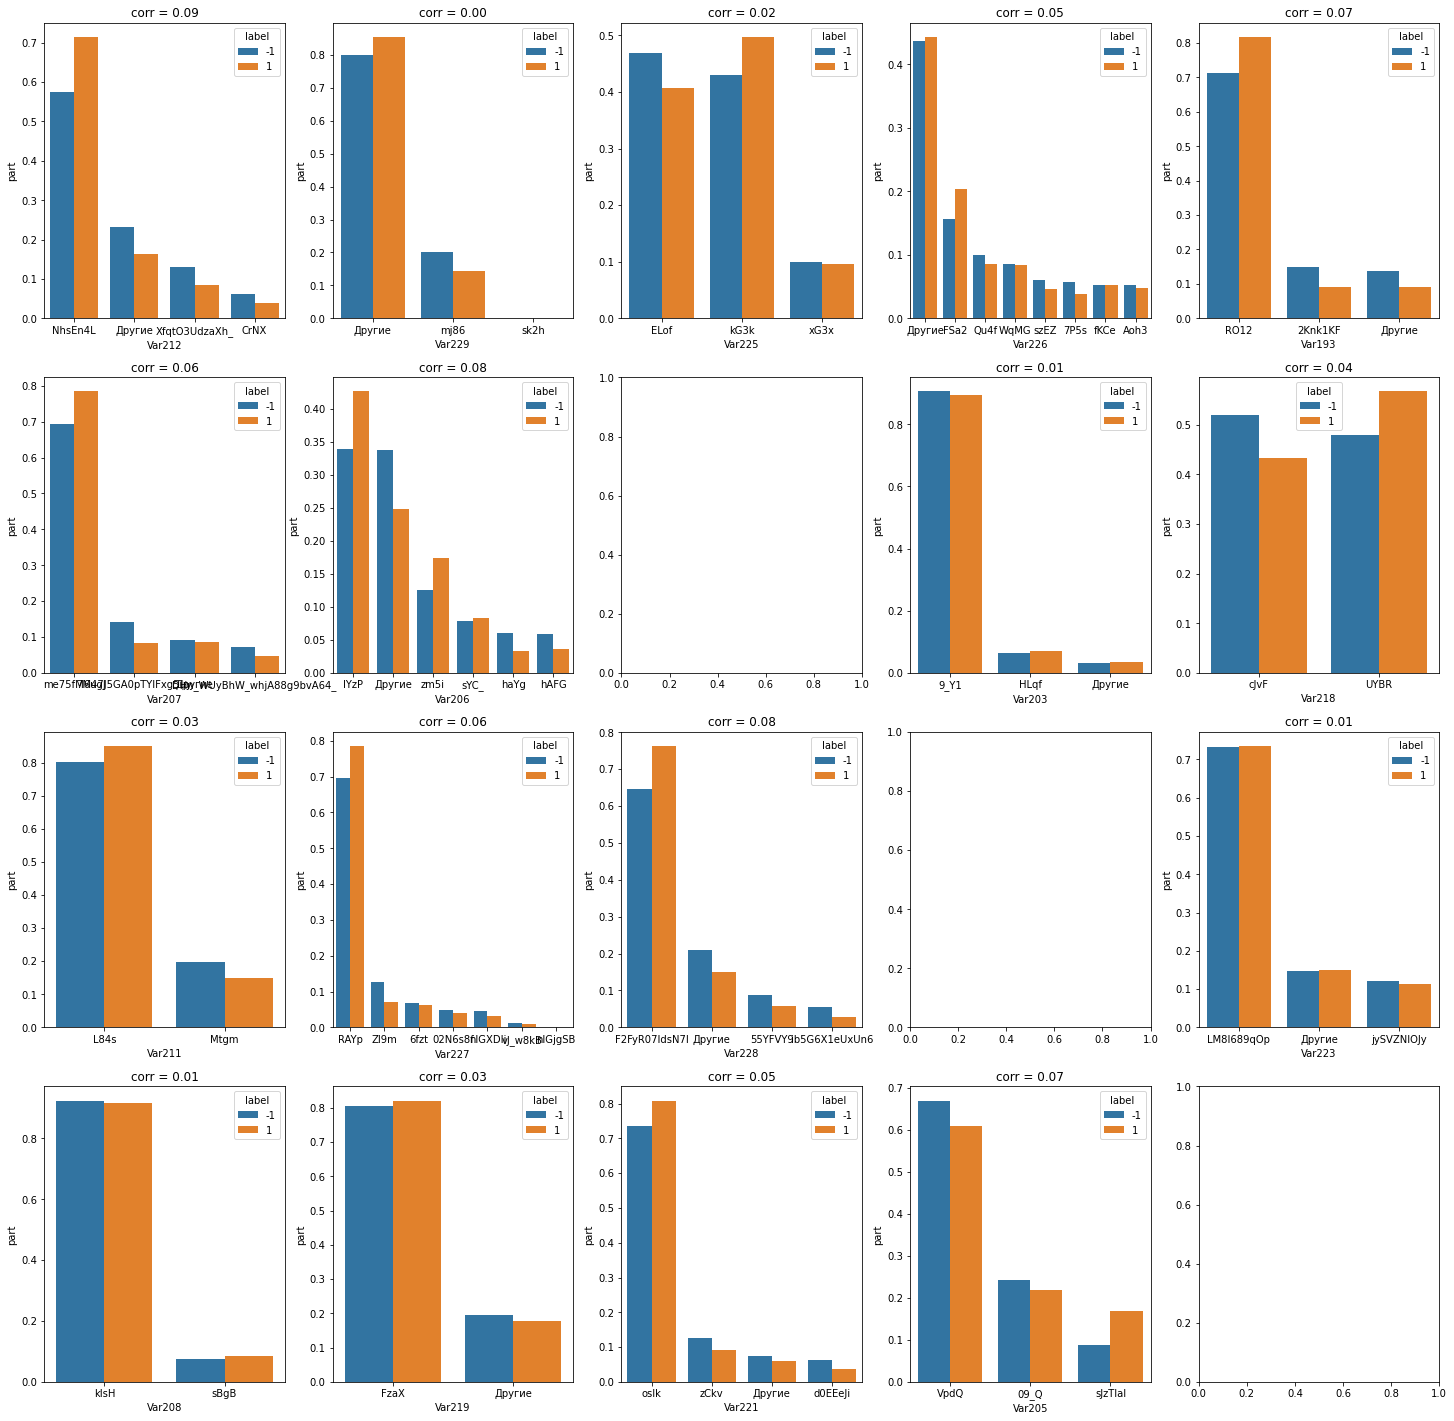

In [208]:
fig, axes = plt.subplots(4, 5, figsize=(25, 25))
for k, name in enumerate(cat):
    temp = dt_category.groupby('label')[name].value_counts(normalize=True).reset_index('label').rename(columns={name: 'part'}).reset_index()
    sns.barplot(data=temp, x=name, y='part',  hue='label', ax=axes[k % 4, k % 5])
    axes[k % 4, k % 5].set_title('corr = {:.2f}'.format(correlation_cat[name]))
print('Распределение долей каждого класса всех значений переменной в каждой категории')
plt.show()

Визуально категориальные переменные, распределение которых отличается относительно целевой переменной, являются Var212, Var206, Var228. Коэффиценты V-Крамера для них наибольшие, 0.08 и 0.09

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

У нас много данных. Первичный анализ данных показал, отчего нужно отталкиваться. Во-первых, у нас есть пустые или неизменяющиеся переменные, мы их удалим, они неинформативны. Также у нас есть переменные, в которых более 50 % пропусков.

При построение взаимосвязей между классами и числовыми переменными в гистограммах были отдельные непересекающиеся области в случае, когда коррелированность была наибольшая. Возможно эти признаки действительно, помогут построить какие-то критерии на отбор. Еще по гистаграммам видно, что некоторые числовые признаки на самом деле категориальные и возможно надо попробовать посчитать для них Крамера, а не сравнивать мат. ожидания. В категориальных переменных есть очень маленькие классы, для анализа некоторые пришлось их объединить.

В тексте выше приведены аргументы почему я считаю некоторые прееменные полезными, в основном это те, у которых наибольшая коррелируемость с целевой переменной: Var212, Var206, Var228,  Var168, Var189, Var113, Var126, Var188, Var73


Отбор признаков здесь явно нужен.
